In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import Bounds

The unfiltered SNR Squared per Time is 8.667830721037366e-05

`gtol` termination condition is satisfied.
Number of iterations: 70, function evaluations: 6262, CG iterations: 85, optimality: 5.76e-09, constraint violation: 0.00e+00, execution time: 0.74 s.

The optimized SNR Squared per Time is 0.023453758389392832
The crossover x-value is 0.485
The Analytic solver crossover x-value is 0.47000000000000003
The approximate optimized SNR Squared per Time with a box-car filter is 0.02346934894692778


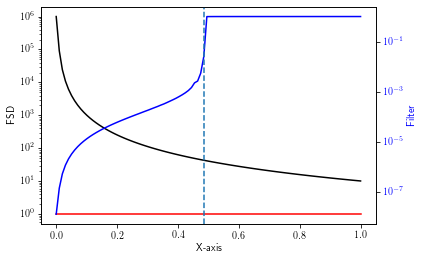

In [7]:
fmin = 0
fmax = 1
fpoints = 100
deltaf = (fmax-fmin)/fpoints
freqs = np.linspace(fmin,fmax,fpoints)


SignalFSD = 0*freqs+1
Lorentz1Center = 0
Lorentz2Center = 3
LorentzMax = 1e6
LorentzValAt1 = 10
NoiseFSD = np.zeros(fpoints)
for i in range(fpoints):
    NoiseFSD[i] = LorentzMax/(1+(LorentzMax/LorentzValAt1)*((fmin+i*deltaf)-Lorentz1Center)**2)

#print(NoiseFSD)

Filter = 0*freqs+1

def SNRsquaredPerTime(Filter):
    Top = 0
    Bottom = 0
    for i in range(0,fpoints):
        Top = Top + SignalFSD[i]*Filter[i]*deltaf
        Bottom = Bottom + (NoiseFSD[i]+SignalFSD[i])*Filter[i]*deltaf
    Total = Top**2 / Bottom
    return Total
Ans = SNRsquaredPerTime(Filter)

def OneMinusSNRsquaredPerTime(Filter):
    return 1 - SNRsquaredPerTime(Filter)

print(f"The unfiltered SNR Squared per Time is {SNRsquaredPerTime(Filter)}")

bounds = Bounds(np.zeros(fpoints),np.zeros(fpoints)+1)
print()
res = minimize(OneMinusSNRsquaredPerTime, 
               Filter, 
               method='trust-constr', 
               options={'verbose': 1}, 
               bounds=bounds)
print()
#print(res.x)
Filter = res.x
print(f"The optimized SNR Squared per Time is {SNRsquaredPerTime(Filter)}")

crossover = 1
crossoverheight = 0.99
crossoveri = fpoints-1
for i in range(fpoints):
    if res.x[fpoints-1-i] > crossoverheight:
        continue
    else:
        crossover = fmin+(fpoints-1/2-i)*deltaf
        crossoveri = fpoints-1-i
        break
print(f"The crossover x-value is {crossover}")

#Analytic solver
crossoverarray = np.array([])
tolerance = 0.1
def NoiseAndSignalBoxFilter(crossoveri):
    Bottom = 0
    for i in range(crossoveri,fpoints):
        Bottom = Bottom + (NoiseFSD[i]+SignalFSD[i])*deltaf
    return Bottom

for i in range(fpoints):
    ans = (1-(fmin+i*deltaf))*NoiseFSD[i]/NoiseAndSignalBoxFilter(i)
    if 2 - tolerance < ans and ans < 2 + tolerance:
        crossoverarray = np.append(crossoverarray,(fmin+i*deltaf))
#print(crossoverarray)
analyticcrossover = np.average(crossoverarray)
print(f"The Analytic solver crossover x-value is {analyticcrossover}")



def SNRsquaredPerTimeBoxFilter(crossoveri):
    Top = 0
    Bottom = 0
    for i in range(crossoveri,fpoints):
        Top = Top + SignalFSD[i]*deltaf
        Bottom = Bottom + (NoiseFSD[i]+SignalFSD[i])*deltaf
    Total = Top**2 / Bottom
    return Total

print(f"The approximate optimized SNR Squared per Time with a box-car filter is {SNRsquaredPerTimeBoxFilter(crossoveri)}")



fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('X-axis') 
ax1.set_ylabel('FSD', color = 'black') 
ax1.plot(freqs, NoiseFSD, color = 'black')
ax1.plot(freqs, SignalFSD, color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'black') 
plt.yscale("log")
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Filter', color = 'blue') 
ax2.plot(freqs, Filter, color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue')

ax2.axvline(crossover, linestyle='--')
 
# Show plot
plt.yscale("log")
plt.show()